# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 34kB/s  eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

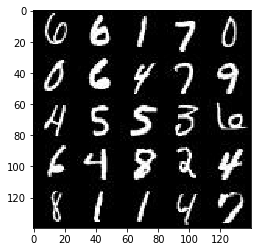

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot
import pickle as pkl

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

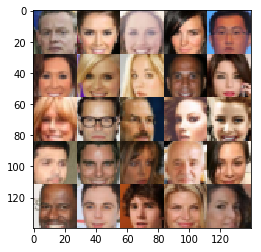

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),name='real_input')
    z_input = tf.placeholder(tf.float32,(None,z_dim),name='z_input')
    learning_rate =  tf.placeholder(tf.float32,(None),name='learning_rate')

    return (real_input,z_input,learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 832, in start\n    self._run_callback(self._callbacks.popleft())', 'File

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

# def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    """
    with tf.variable_scope('discriminator',reuse=reuse):
        x1 = tf.layers.conv2d(images,64,5,strides=2,padding='same')
        x1 = tf.layers.batch_normalization(x1,training=True)
        x1 = tf.maximum(0.2*x1,x1)
        x2 = tf.layers.conv2d(x1,128,5,strides=2,padding='same')
        x2 = tf.layers.batch_normalization(x2,training=True)
        x2 = tf.maximum(0.2*x2,x2)
        x3 = tf.layers.conv2d(x2,256,5,strides=2,padding='same')
        x3 = tf.layers.batch_normalization(x3,training=True)
        x3 = tf.maximum(0.2*x3,x3)
        x4 = tf.layers.conv2d(x3,512,5,strides=2,padding='same')
        x4 = tf.layers.batch_normalization(x4,training=True)
        x4 = tf.maximum(0.2*x4,x4)
        flat = tf.reshape(x4,(-1,4*4*512))
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)
    return (out, logits)  
    
    
    
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator',reuse=reuse):
        xavier = tf.contrib.layers.xavier_initializer(uniform=True,seed=1,dtype=tf.float32)
        x1 = tf.layers.conv2d(images,64,4,strides=2,padding='same',kernel_initializer=xavier)
        x1 = tf.layers.batch_normalization(x1,training=True)
        x1 = tf.layers.dropout(x1,rate=0.15,training=True)
        x1 = tf.maximum(0.2*x1,x1)
        x2 = tf.layers.conv2d(x1,128,4,strides=2,padding='same',kernel_initializer=xavier)
        x2 = tf.layers.batch_normalization(x2,training=True)
        x2= tf.layers.dropout(x2,rate=0.15,training=True)
        x2 = tf.maximum(0.2*x2,x2)
        x3 = tf.layers.conv2d(x2,256,4,strides=2,padding='same',kernel_initializer=xavier)
        x3 = tf.layers.batch_normalization(x3,training=True)
        x3= tf.layers.dropout(x3,rate=0.15,training=True)
        x3 = tf.maximum(0.2*x3,x3)
        flat = tf.reshape(x3,(-1,4*4*256))
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)
    return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

In [6]:
def discriminator(images, reuse=False):

    
    # TODO: Implement Function
        
    with tf.variable_scope('discriminator',reuse=reuse):
        xavier = tf.contrib.layers.xavier_initializer(uniform=True,seed=1,dtype=tf.float32)
        x1 = tf.layers.conv2d(images,64,4,strides=2,padding='same',kernel_initializer=xavier)
        x1 = tf.layers.batch_normalization(x1,momentum=0.9,training=True)
        x1 = tf.layers.dropout(x1,rate=0.2,training=True)
        x1 = tf.maximum(0.2*x1,x1)
        x2 = tf.layers.conv2d(x1,128,4,strides=2,padding='same',kernel_initializer=xavier)
        x2 = tf.layers.batch_normalization(x2,momentum=0.9,training=True)
        x2= tf.layers.dropout(x2,rate=0.1,training=True)
        x2 = tf.maximum(0.2*x2,x2)
        x3 = tf.layers.conv2d(x2,256,4,strides=2,padding='same',kernel_initializer=xavier)
        x3 = tf.layers.batch_normalization(x3,momentum=0.9,training=True)
        x3= tf.layers.dropout(x3,rate=0.1,training=True)
        x3 = tf.maximum(0.2*x3,x3)
        flat = tf.reshape(x3,(-1,4*4*256))
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)
    return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

# def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function

    """
    reuse = not is_train
    with tf.variable_scope('generator',reuse=reuse):
        x1 = tf.layers.dense(z,4*4*448)
        x1 = tf.reshape(x1,(-1,4,4,448))
        x = tf.layers.conv2d_transpose(x1,448,2,strides=1,padding='same')
        x = tf.layers.batch_normalization(x,training=reuse)
        x = tf.maximum(0.2*x,x)
        x = tf.layers.conv2d_transpose(x,224,2,strides=1,padding='same')
        x = tf.layers.batch_normalization(x,training=reuse)
        x = tf.maximum(0.2*x,x)
        x2 = tf.layers.conv2d_transpose(x,112,4,strides=1,padding='valid')
        x2 = tf.layers.batch_normalization(x2,training=reuse)
        x2 = tf.maximum(0.2*x2,x2)
        x3 = tf.layers.conv2d_transpose(x2,56,2,strides=2,padding='same')
        x3 = tf.layers.batch_normalization(x3,training=reuse)
        x3 = tf.maximum(0.2*x3,x3)
        logits = tf.layers.conv2d_transpose(x3,out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
        
    return out
    """

    # TODO: Implement Function
    reuse = not is_train
    alpha=0.2
    with tf.variable_scope('generator', reuse=reuse):
        x = tf.layers.dense(z, 4*4*512)
        
        x = tf.reshape(x, (-1,4,4,512))
        x = tf.layers.batch_normalization(x,training=is_train)
        x = tf.maximum(alpha * x, x)
        x = tf.layers.conv2d_transpose(x, 256, 4, strides=1, padding="valid")
        x = tf.layers.batch_normalization(x,training=is_train)
        x = tf.maximum(alpha * x, x)
        x = tf.layers.conv2d_transpose(x, 128, 4, strides=2, padding="same")
        x = tf.layers.batch_normalization(x,training=is_train)
        x = tf.maximum(alpha * x, x)
        x = tf.layers.conv2d_transpose(x, out_channel_dim, 4, strides=2, padding="same")
        logits = x
        out = tf.tanh(logits)
    return out









"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

In [7]:

def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """

    # TODO: Implement Function
    reuse = not is_train
    alpha=0.2
    
    with tf.variable_scope('generator', reuse=reuse):
        
        x = tf.layers.dense(z, 4*4*512)
        
        x = tf.reshape(x, (-1,4,4,512))
        x = tf.layers.batch_normalization(x,training=is_train)
        x = tf.maximum(alpha * x, x)
        x = tf.layers.conv2d_transpose(x, 256, 4, strides=1, padding="valid")
        x = tf.layers.batch_normalization(x,training=is_train)
        x = tf.maximum(alpha * x, x)
        x = tf.layers.conv2d_transpose(x, 128, 4, strides=2, padding="same")
        x = tf.layers.batch_normalization(x,training=is_train)
        x = tf.maximum(alpha * x, x)
        x = tf.layers.conv2d_transpose(x, out_channel_dim, 4, strides=2, padding="same")
        logits = x
        out = tf.tanh(logits)
    return out









"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

# def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    import random
    #smooth_ones = random.uniform(0.1,-0.1)
    smooth_ones = 0.1
    #smooth_zeros = random.uniform(0.0,0.1)
    g_model = generator(input_z,out_channel_dim,True)
    d_model_real, d_model_logits = discriminator(input_real,False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_model_logits,labels=tf.ones_like(d_model_real)*(1-smooth_ones)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)*(1-smooth_ones)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss

### The label smoothig has been done by using smoothing tips at following link https://github.com/soumith/ganhacks
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    import random
    #smooth_ones = random.uniform(0.1,-0.1)
    smooth_ones = 0.1
    #smooth_zeros = random.uniform(0.0,0.1)
    
    g_model = generator(input_z,out_channel_dim,True)
    d_model_real, d_model_logits = discriminator(input_real,False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_model_logits,labels=tf.ones_like(d_model_real)*(1-smooth_ones)))
    d_loss_fake = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)*(1-smooth_ones)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss

# The label smoothig has been done by using smoothing tips at following link https://github.com/soumith/ganhacks
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate,beta1).minimize(d_loss,var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate,beta1).minimize(g_loss,var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

In [11]:
mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
asd = mnist_dataset.shape
adf = mnist_dataset.get_batches

In [12]:
imag3e = adf(300)

In [13]:
for image in imag3e:
    print(image.shape) 
    break

(300, 28, 28, 1)


In [14]:
#The input images have their values between -0.5 qnd 0.5
#Here is the method to normalize using min max scaling but the output is yeilding a value between 0 and 1
# A different variation was tried but stil didnt converge to -1 between 1
# tf function batch_standardization also didnt output the desired range


from skimage.transform import rescale
import numpy as np
celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
gt = celeba_dataset.get_batches
for batch_images in gt(4):
    for i in batch_images:
        print(i.shape)
        x = np.array(i)
        x = np.reshape(x,(1,2352))
        min1 = np.min(x)
        max1 = np.max(x)
        print("Regular min: ",min1)
        print("Regular max: ",max1)
        print(x.shape)
        print("regular value",x[0][10])
        
        #below formula to obtain range of -1 to 1 but it isnt, read it on a website
        x1 = 2*(x - min1 )/((max1-min1)-1)
        print("Method 1 min ",np.min(x1))
        print("Method 1 max ",np.max(x1))
        print("Method 1 value ",x1[0][10])
        
        #Regular min max
        x2 = (x - min1 )/(max1-min1)
        print("Method 2 min ",np.min(x2))
        print("Method 2 max ",np.max(x2))
        print("Method 2 value ",x2[0][10])
        
        
        #Standardization
        #frame = tf.placeholder(tf.float32,[28,28,3],name="frame")
        frame = tf.image.per_image_standardization(i)
        max_f = tf.reduce_max(frame)
        min_f = tf.reduce_min(frame)
        sess = tf.Session()
        sess.run(tf.global_variables_initializer())
        print("Method 3 max ",sess.run(max_f))
        print("Method 3 min ",sess.run(min_f))
        sess.close
        
        print("\n\n")
        
    break

(28, 28, 3)
Regular min:  -0.421569
Regular max:  0.382353
(1, 2352)
regular value -0.217647
Method 1 min  -8.2
Method 1 max  -0.0
Method 1 value  -2.08
Method 2 min  0.0
Method 2 max  1.0
Method 2 value  0.253659
Method 3 max  2.1239
Method 3 min  -2.37566



(28, 28, 3)
Regular min:  -0.452941
Regular max:  0.460784
(1, 2352)
regular value -0.280392
Method 1 min  -21.1818
Method 1 max  -0.0
Method 1 value  -4.0
Method 2 min  0.0
Method 2 max  1.0
Method 2 value  0.188841
Method 3 max  2.23008
Method 3 min  -1.53656



(28, 28, 3)
Regular min:  -0.468627
Regular max:  0.5
(1, 2352)
regular value -0.233333
Method 1 min  -61.75
Method 1 max  -0.0
Method 1 value  -15.0
Method 2 min  0.0
Method 2 max  1.0
Method 2 value  0.242915
Method 3 max  1.77976
Method 3 min  -2.14625



(28, 28, 3)
Regular min:  -0.472549
Regular max:  0.5
(1, 2352)
regular value -0.378431
Method 1 min  -70.8571
Method 1 max  -0.0
Method 1 value  -6.85714
Method 2 min  0.0
Method 2 max  1.0
Method 2 value  0.096774

In [15]:
def convert_minus_one_to_one(batch_images):
    batch_image = tf.convert_to_tensor(batch_images)
    batch_images = tf.scalar_mul(2,batch_image)
    return batch_images

In [16]:
def convert_tensor_to_array(batch_images):
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    array = batch_images.eval(session=sess)
    return array

In [17]:
#Since all our images are between range -0.5 to 0.5 a simple multiplication by 2 can rescale the images to lie between -1 and 1


celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
gt = celeba_dataset.get_batches
s = 0
for batch_images in gt(4):
    s += 1
    batch_image = tf.convert_to_tensor(batch_images)
    print(batch_image.shape)
    batch = convert_minus_one_to_one(batch_image) 
    max_f = tf.reduce_max(batch)
    min_f = tf.reduce_min(batch)
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    print("Method 4 max ",sess.run(max_f))
    print("Method 4 min ",sess.run(min_f))
    print(batch.shape)
    sess.close
    if s > 3:
        break

(4, 28, 28, 3)
Method 4 max  1.0
Method 4 min  -0.945098
(4, 28, 28, 3)
(4, 28, 28, 3)
Method 4 max  1.0
Method 4 min  -1.0
(4, 28, 28, 3)
(4, 28, 28, 3)
Method 4 max  0.976471
Method 4 min  -0.976471
(4, 28, 28, 3)
(4, 28, 28, 3)
Method 4 max  0.992157
Method 4 min  -1.0
(4, 28, 28, 3)


### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [19]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    data_mode = data_image_mode
    real_input,z_input,learning_rate_real = model_inputs(image_width, image_height, image_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, image_channels )
    
    learning_rate_real = learning_rate
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss,learning_rate_real, beta1)
    
    steps = 0
    
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # TODO: Train Model
                #rescaling the images
                z_noiseinput = np.random.uniform(-1,1,size=(batch_size,z_dim))
                bt_im = convert_minus_one_to_one(batch_images)
                batch_images = convert_tensor_to_array(bt_im)
                _ = sess.run(d_train_opt, feed_dict={real_input:batch_images, z_input:z_noiseinput})
                _ = sess.run(g_train_opt, feed_dict={z_input:z_noiseinput,real_input:batch_images})
                
                
                if steps % 100 == 0:
                    train_loss_d = d_loss.eval({z_input:z_noiseinput,real_input:batch_images})
                    train_loss_g = g_loss.eval({z_input:z_noiseinput})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % 400 == 0:
                       show_generator_output(sess, 25, z_input,image_channels,data_mode)
                    

        
         
        
                

Epoch 1/2... Discriminator Loss: 2.3706... Generator Loss: 0.4264
Epoch 1/2... Discriminator Loss: 1.4696... Generator Loss: 1.5110
Epoch 1/2... Discriminator Loss: 1.5934... Generator Loss: 1.2624
Epoch 1/2... Discriminator Loss: 1.6678... Generator Loss: 0.4386


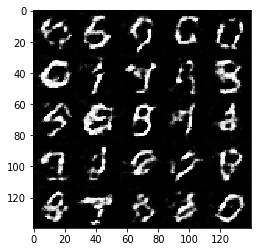

Epoch 1/2... Discriminator Loss: 1.4406... Generator Loss: 1.0671
Epoch 1/2... Discriminator Loss: 1.3613... Generator Loss: 0.6352
Epoch 1/2... Discriminator Loss: 1.1813... Generator Loss: 1.2619
Epoch 1/2... Discriminator Loss: 1.2180... Generator Loss: 1.0139


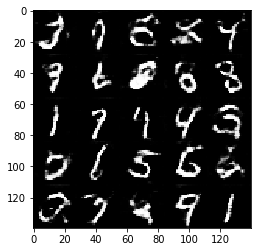

KeyboardInterrupt: 

In [19]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [24]:
batch_size = 16
z_dim = 100
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 8

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

KeyboardInterrupt: 

### loss not improving for above model

Epoch 1/8... Discriminator Loss: 1.6585... Generator Loss: 0.8437
Epoch 1/8... Discriminator Loss: 1.3759... Generator Loss: 1.5016
Epoch 1/8... Discriminator Loss: 0.8979... Generator Loss: 1.8259
Epoch 1/8... Discriminator Loss: 1.2265... Generator Loss: 0.6952


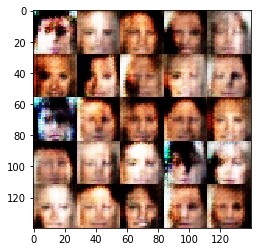

Epoch 1/8... Discriminator Loss: 1.1251... Generator Loss: 2.6771
Epoch 1/8... Discriminator Loss: 0.9105... Generator Loss: 1.4989
Epoch 1/8... Discriminator Loss: 0.9927... Generator Loss: 2.1273
Epoch 1/8... Discriminator Loss: 0.8965... Generator Loss: 1.5862


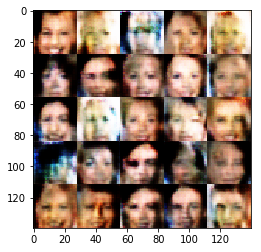

Epoch 1/8... Discriminator Loss: 0.9029... Generator Loss: 1.9613
Epoch 1/8... Discriminator Loss: 0.6217... Generator Loss: 2.1038
Epoch 1/8... Discriminator Loss: 1.0401... Generator Loss: 2.7161
Epoch 1/8... Discriminator Loss: 1.2354... Generator Loss: 2.3504


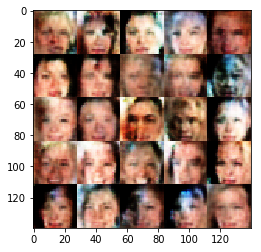

Epoch 1/8... Discriminator Loss: 0.7480... Generator Loss: 3.1621
Epoch 1/8... Discriminator Loss: 0.7573... Generator Loss: 1.4260
Epoch 1/8... Discriminator Loss: 1.8791... Generator Loss: 3.7858
Epoch 1/8... Discriminator Loss: 0.9705... Generator Loss: 1.2841


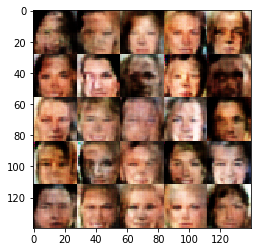

Epoch 1/8... Discriminator Loss: 0.9094... Generator Loss: 2.3975
Epoch 1/8... Discriminator Loss: 0.8711... Generator Loss: 3.2473
Epoch 1/8... Discriminator Loss: 0.8113... Generator Loss: 1.6101
Epoch 1/8... Discriminator Loss: 1.0939... Generator Loss: 1.0371


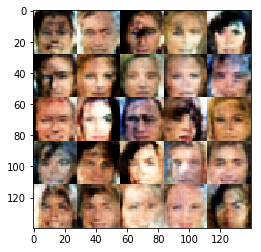

Epoch 1/8... Discriminator Loss: 0.7804... Generator Loss: 3.0139
Epoch 1/8... Discriminator Loss: 0.8798... Generator Loss: 1.4422
Epoch 1/8... Discriminator Loss: 0.7418... Generator Loss: 2.0695
Epoch 1/8... Discriminator Loss: 1.1443... Generator Loss: 0.9701


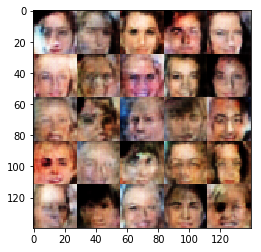

Epoch 1/8... Discriminator Loss: 0.7519... Generator Loss: 2.1854
Epoch 1/8... Discriminator Loss: 0.8959... Generator Loss: 1.6182
Epoch 1/8... Discriminator Loss: 0.8664... Generator Loss: 1.0810
Epoch 1/8... Discriminator Loss: 0.5929... Generator Loss: 3.0035


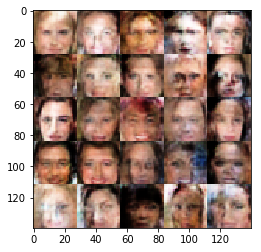

Epoch 1/8... Discriminator Loss: 0.7924... Generator Loss: 3.1183
Epoch 1/8... Discriminator Loss: 1.1320... Generator Loss: 1.2033
Epoch 1/8... Discriminator Loss: 0.7909... Generator Loss: 1.6360


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 8

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

Epoch 1/2... Discriminator Loss: 0.0565... Generator Loss: 2.5647
Epoch 1/2... Discriminator Loss: 0.7554... Generator Loss: 0.9309
Epoch 1/2... Discriminator Loss: 0.6914... Generator Loss: 0.6455
Epoch 1/2... Discriminator Loss: 0.4618... Generator Loss: 1.0342


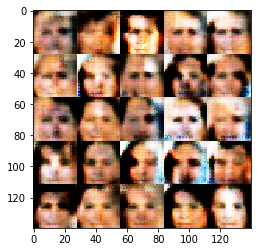

Epoch 1/2... Discriminator Loss: 0.9749... Generator Loss: 0.5994
Epoch 1/2... Discriminator Loss: 0.4403... Generator Loss: 1.4242
Epoch 1/2... Discriminator Loss: 1.7951... Generator Loss: 5.9438
Epoch 1/2... Discriminator Loss: 0.7762... Generator Loss: 3.2510


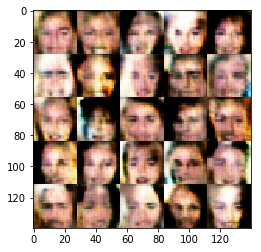

Epoch 1/2... Discriminator Loss: 1.7805... Generator Loss: 2.5778
Epoch 1/2... Discriminator Loss: 2.1857... Generator Loss: 0.2659
Epoch 1/2... Discriminator Loss: 0.2904... Generator Loss: 1.4073
Epoch 1/2... Discriminator Loss: 0.1412... Generator Loss: 1.4602


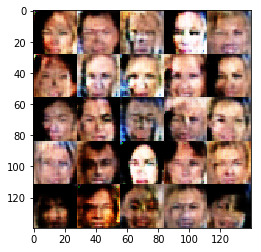

Epoch 1/2... Discriminator Loss: 0.4551... Generator Loss: 1.8238
Epoch 1/2... Discriminator Loss: -0.2165... Generator Loss: 2.3897
Epoch 1/2... Discriminator Loss: 0.0761... Generator Loss: 1.8581
Epoch 1/2... Discriminator Loss: 0.0571... Generator Loss: 2.1817


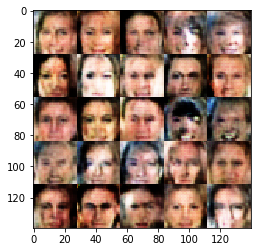

Epoch 1/2... Discriminator Loss: 0.0875... Generator Loss: 5.2291
Epoch 1/2... Discriminator Loss: 0.2977... Generator Loss: 1.9891
Epoch 1/2... Discriminator Loss: 0.8922... Generator Loss: 0.2671
Epoch 1/2... Discriminator Loss: -0.1574... Generator Loss: 1.7016


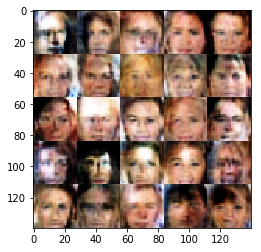

Epoch 1/2... Discriminator Loss: 0.2014... Generator Loss: 3.5478
Epoch 1/2... Discriminator Loss: 0.6725... Generator Loss: 0.7145
Epoch 1/2... Discriminator Loss: 1.4917... Generator Loss: 0.3383
Epoch 1/2... Discriminator Loss: -0.0067... Generator Loss: 2.5596


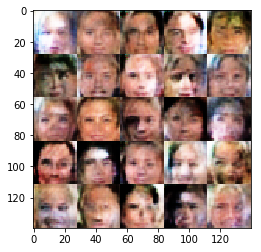

Epoch 1/2... Discriminator Loss: 0.7059... Generator Loss: 4.7234
Epoch 1/2... Discriminator Loss: -0.0340... Generator Loss: 2.9045
Epoch 1/2... Discriminator Loss: 0.2842... Generator Loss: 3.2691
Epoch 1/2... Discriminator Loss: -0.0516... Generator Loss: 1.2777


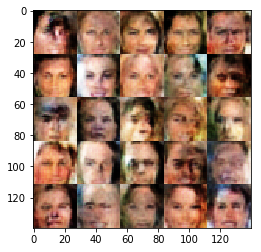

KeyboardInterrupt: 

In [21]:
batch_size = 24
z_dim = 100
learning_rate = 0.00105
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### The above model has collapsed due to extremely skewed losses

Epoch 1/2... Discriminator Loss: 1.1591... Generator Loss: 1.4280
Epoch 1/2... Discriminator Loss: 0.9840... Generator Loss: 2.0038
Epoch 1/2... Discriminator Loss: 0.8558... Generator Loss: 2.9509
Epoch 1/2... Discriminator Loss: 0.7958... Generator Loss: 3.7177


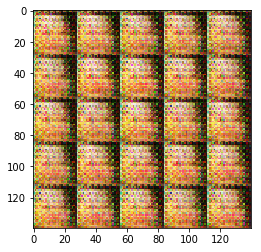

Epoch 1/2... Discriminator Loss: 0.8027... Generator Loss: 3.3080
Epoch 1/2... Discriminator Loss: 0.8117... Generator Loss: 3.0790
Epoch 1/2... Discriminator Loss: 0.7856... Generator Loss: 3.6596
Epoch 1/2... Discriminator Loss: 0.8063... Generator Loss: 2.8876


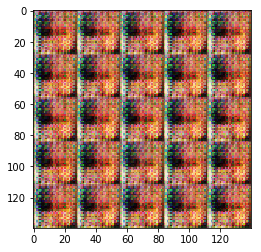

Epoch 1/2... Discriminator Loss: 0.7914... Generator Loss: 3.9824
Epoch 1/2... Discriminator Loss: 0.7593... Generator Loss: 3.3528
Epoch 1/2... Discriminator Loss: 0.7565... Generator Loss: 4.1373
Epoch 1/2... Discriminator Loss: 0.7511... Generator Loss: 3.9077


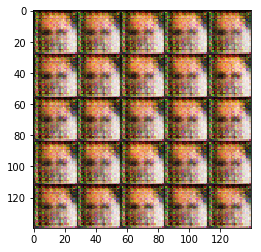

KeyboardInterrupt: 

In [22]:
batch_size = 16
z_dim = 100
learning_rate = 0.0001
beta1 = 0.15


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

Epoch 1/2... Discriminator Loss: 1.3336... Generator Loss: 1.0126
Epoch 1/2... Discriminator Loss: 1.2421... Generator Loss: 1.1650
Epoch 1/2... Discriminator Loss: 1.2482... Generator Loss: 1.1824
Epoch 1/2... Discriminator Loss: 1.1879... Generator Loss: 1.2523


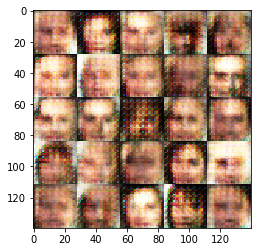

Epoch 1/2... Discriminator Loss: 1.4025... Generator Loss: 1.8444
Epoch 1/2... Discriminator Loss: 1.4964... Generator Loss: 0.6274
Epoch 1/2... Discriminator Loss: 1.2762... Generator Loss: 1.0801
Epoch 1/2... Discriminator Loss: 1.2217... Generator Loss: 1.0674


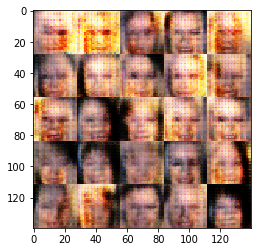

Epoch 1/2... Discriminator Loss: 1.2602... Generator Loss: 1.4511
Epoch 1/2... Discriminator Loss: 1.2569... Generator Loss: 1.2010
Epoch 1/2... Discriminator Loss: 1.2386... Generator Loss: 1.2529
Epoch 1/2... Discriminator Loss: 1.2317... Generator Loss: 1.1725


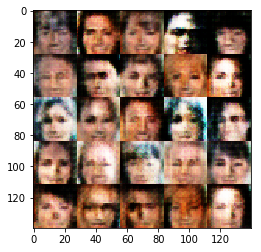

Epoch 1/2... Discriminator Loss: 1.2621... Generator Loss: 1.0986
Epoch 1/2... Discriminator Loss: 1.2384... Generator Loss: 1.1716
Epoch 1/2... Discriminator Loss: 1.2703... Generator Loss: 1.1882
Epoch 1/2... Discriminator Loss: 1.2483... Generator Loss: 1.1529


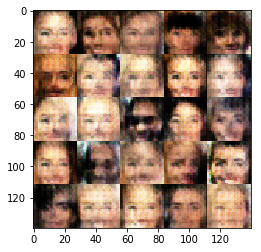

Epoch 1/2... Discriminator Loss: 1.2687... Generator Loss: 1.0603
Epoch 1/2... Discriminator Loss: 1.1735... Generator Loss: 1.1866
Epoch 1/2... Discriminator Loss: 1.2266... Generator Loss: 1.1692
Epoch 1/2... Discriminator Loss: 1.2403... Generator Loss: 1.0818


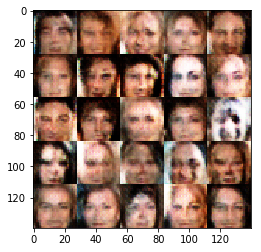

Epoch 1/2... Discriminator Loss: 1.2544... Generator Loss: 1.3170
Epoch 1/2... Discriminator Loss: 1.2418... Generator Loss: 1.4123
Epoch 1/2... Discriminator Loss: 1.2420... Generator Loss: 1.2744
Epoch 1/2... Discriminator Loss: 1.1951... Generator Loss: 1.2569


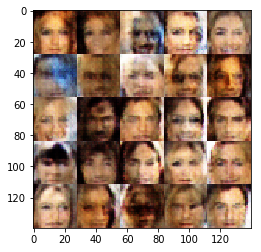

Epoch 1/2... Discriminator Loss: 1.2178... Generator Loss: 1.1175
Epoch 1/2... Discriminator Loss: 1.2322... Generator Loss: 1.1407
Epoch 1/2... Discriminator Loss: 1.2310... Generator Loss: 1.0893
Epoch 1/2... Discriminator Loss: 1.2687... Generator Loss: 1.0690


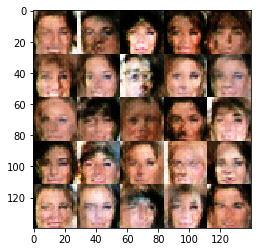

Epoch 1/2... Discriminator Loss: 1.1814... Generator Loss: 1.1492
Epoch 1/2... Discriminator Loss: 1.2063... Generator Loss: 1.0357
Epoch 1/2... Discriminator Loss: 1.2973... Generator Loss: 0.9641
Epoch 1/2... Discriminator Loss: 1.2510... Generator Loss: 1.1242


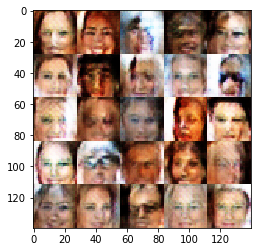

Epoch 1/2... Discriminator Loss: 1.2586... Generator Loss: 1.0690
Epoch 1/2... Discriminator Loss: 1.2141... Generator Loss: 1.0876
Epoch 1/2... Discriminator Loss: 1.2611... Generator Loss: 1.1125
Epoch 1/2... Discriminator Loss: 1.2964... Generator Loss: 0.9962


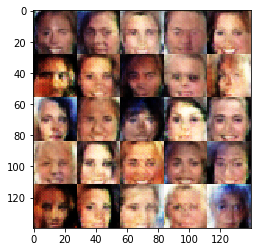

Epoch 1/2... Discriminator Loss: 1.2531... Generator Loss: 1.2096
Epoch 1/2... Discriminator Loss: 1.2883... Generator Loss: 1.2679
Epoch 1/2... Discriminator Loss: 1.2359... Generator Loss: 1.1239
Epoch 1/2... Discriminator Loss: 1.2366... Generator Loss: 1.1665


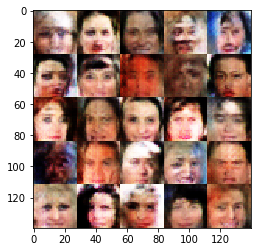

Epoch 1/2... Discriminator Loss: 1.2748... Generator Loss: 1.0922
Epoch 1/2... Discriminator Loss: 1.2629... Generator Loss: 0.9994
Epoch 1/2... Discriminator Loss: 1.1967... Generator Loss: 1.1620


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### The above model is oscillating in a very small range with no significant movement in losses

In [ ]:
#Above models had a dropout range of 0.2 it is reduced to 0.1
#label one smoothing range has been reduced from (0.3,-0.1) to value 0.9 and label zero smoothing has been stopped
#Will try three combinations of hyperparameters, lr: batch_size, 0.002:32, 0.0001:16, 0.001:24 and beta at 0.2

Epoch 1/2... Discriminator Loss: 2.1620... Generator Loss: 0.4390
Epoch 1/2... Discriminator Loss: 1.5792... Generator Loss: 0.7144
Epoch 1/2... Discriminator Loss: 1.3761... Generator Loss: 0.8729
Epoch 1/2... Discriminator Loss: 1.2372... Generator Loss: 0.7375


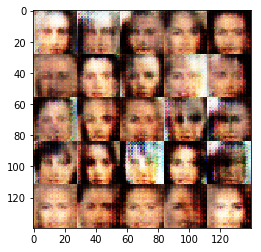

Epoch 1/2... Discriminator Loss: 1.4862... Generator Loss: 1.1722
Epoch 1/2... Discriminator Loss: 1.4943... Generator Loss: 0.5838
Epoch 1/2... Discriminator Loss: 1.3361... Generator Loss: 0.6225
Epoch 1/2... Discriminator Loss: 1.2867... Generator Loss: 0.6531


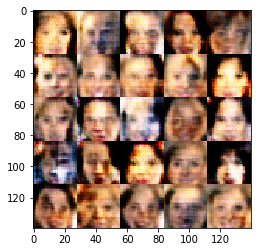

Epoch 1/2... Discriminator Loss: 1.4641... Generator Loss: 0.4888
Epoch 1/2... Discriminator Loss: 1.4185... Generator Loss: 0.6429
Epoch 1/2... Discriminator Loss: 1.3232... Generator Loss: 1.1889
Epoch 1/2... Discriminator Loss: 0.8128... Generator Loss: 1.2470


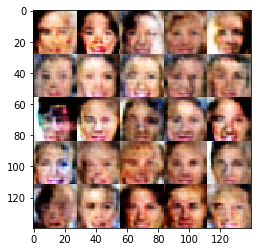

Epoch 1/2... Discriminator Loss: 1.2371... Generator Loss: 0.6601
Epoch 1/2... Discriminator Loss: 0.8900... Generator Loss: 1.0198
Epoch 1/2... Discriminator Loss: 1.1643... Generator Loss: 0.9039
Epoch 1/2... Discriminator Loss: 1.2091... Generator Loss: 1.0829


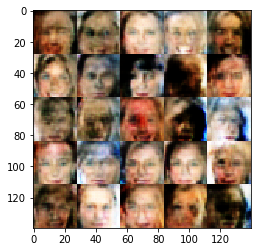

Epoch 1/2... Discriminator Loss: 0.5713... Generator Loss: 1.8733
Epoch 1/2... Discriminator Loss: 1.2468... Generator Loss: 1.1833
Epoch 1/2... Discriminator Loss: 1.3792... Generator Loss: 0.7077
Epoch 1/2... Discriminator Loss: 1.1490... Generator Loss: 0.7717


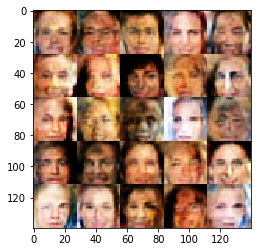

Epoch 1/2... Discriminator Loss: 1.6627... Generator Loss: 0.4652
Epoch 1/2... Discriminator Loss: 1.2337... Generator Loss: 0.8166
Epoch 1/2... Discriminator Loss: 0.8527... Generator Loss: 1.6260
Epoch 1/2... Discriminator Loss: 1.4472... Generator Loss: 1.3400


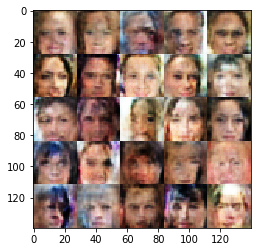

Epoch 1/2... Discriminator Loss: 1.1547... Generator Loss: 0.6600
Epoch 1/2... Discriminator Loss: 1.5836... Generator Loss: 0.6610
Epoch 1/2... Discriminator Loss: 1.5378... Generator Loss: 0.5285
Epoch 1/2... Discriminator Loss: 1.3675... Generator Loss: 1.0736


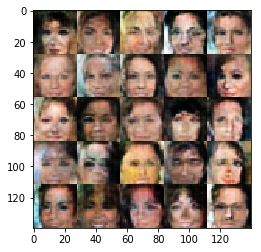

Epoch 1/2... Discriminator Loss: 1.0568... Generator Loss: 1.0912
Epoch 1/2... Discriminator Loss: 1.2433... Generator Loss: 0.9030
Epoch 1/2... Discriminator Loss: 1.2899... Generator Loss: 0.6891
Epoch 1/2... Discriminator Loss: 0.6742... Generator Loss: 1.6991


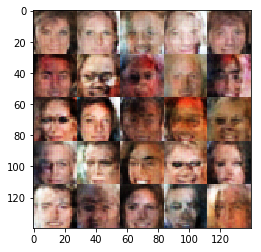

Epoch 1/2... Discriminator Loss: 1.2599... Generator Loss: 1.1650
Epoch 1/2... Discriminator Loss: 1.4810... Generator Loss: 0.5213
Epoch 1/2... Discriminator Loss: 1.0933... Generator Loss: 1.2044


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

Epoch 1/2... Discriminator Loss: 0.8551... Generator Loss: 1.5039
Epoch 1/2... Discriminator Loss: 1.4691... Generator Loss: 0.5609
Epoch 1/2... Discriminator Loss: 0.4786... Generator Loss: 2.9402
Epoch 1/2... Discriminator Loss: 1.5004... Generator Loss: 2.5654


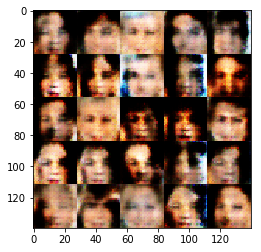

Epoch 1/2... Discriminator Loss: 1.1362... Generator Loss: 1.3888
Epoch 1/2... Discriminator Loss: 1.1302... Generator Loss: 1.4291
Epoch 1/2... Discriminator Loss: 0.4008... Generator Loss: 3.6855
Epoch 1/2... Discriminator Loss: 1.0341... Generator Loss: 0.6363


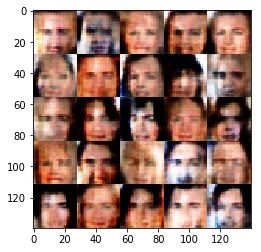

Epoch 1/2... Discriminator Loss: 0.7998... Generator Loss: 1.4836
Epoch 1/2... Discriminator Loss: 1.3274... Generator Loss: 0.8376
Epoch 1/2... Discriminator Loss: 0.4953... Generator Loss: 2.3897
Epoch 1/2... Discriminator Loss: 0.7110... Generator Loss: 1.9579


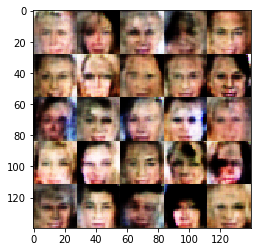

Epoch 1/2... Discriminator Loss: 0.4438... Generator Loss: 2.9511
Epoch 1/2... Discriminator Loss: 0.5055... Generator Loss: 2.2359
Epoch 1/2... Discriminator Loss: 0.7315... Generator Loss: 1.7606
Epoch 1/2... Discriminator Loss: 0.4558... Generator Loss: 2.9133


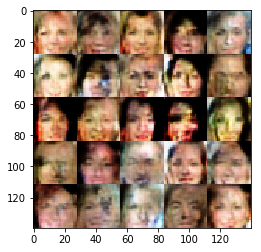

Epoch 1/2... Discriminator Loss: 0.6132... Generator Loss: 3.4198
Epoch 1/2... Discriminator Loss: 0.6712... Generator Loss: 1.5400
Epoch 1/2... Discriminator Loss: 0.6290... Generator Loss: 2.8605
Epoch 1/2... Discriminator Loss: 0.8488... Generator Loss: 3.7706


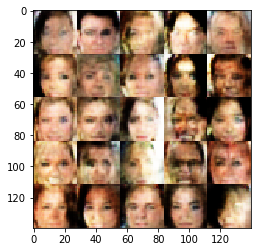

Epoch 1/2... Discriminator Loss: 0.6036... Generator Loss: 2.1269


KeyboardInterrupt: 

In [20]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

###  Above model was stopped as discriminators loss was way to less then generator and that reduced the incentive for generator to improve

Epoch 1/2... Discriminator Loss: 1.5257... Generator Loss: 1.0031
Epoch 1/2... Discriminator Loss: 1.2360... Generator Loss: 0.9518
Epoch 1/2... Discriminator Loss: 1.5409... Generator Loss: 1.0047
Epoch 1/2... Discriminator Loss: 1.3440... Generator Loss: 0.5382


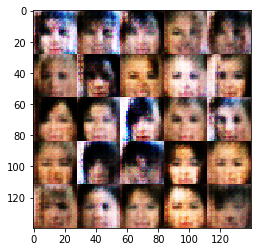

Epoch 1/2... Discriminator Loss: 1.3395... Generator Loss: 0.9402
Epoch 1/2... Discriminator Loss: 2.0140... Generator Loss: 0.3985
Epoch 1/2... Discriminator Loss: 1.5638... Generator Loss: 1.4264
Epoch 1/2... Discriminator Loss: 1.3441... Generator Loss: 1.0652


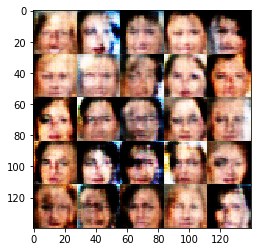

Epoch 1/2... Discriminator Loss: 1.5986... Generator Loss: 0.4815
Epoch 1/2... Discriminator Loss: 1.2747... Generator Loss: 1.5525
Epoch 1/2... Discriminator Loss: 1.5553... Generator Loss: 0.4631
Epoch 1/2... Discriminator Loss: 1.2831... Generator Loss: 2.0352


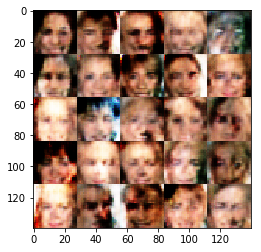

Epoch 1/2... Discriminator Loss: 0.9639... Generator Loss: 0.7302
Epoch 1/2... Discriminator Loss: 0.8762... Generator Loss: 0.9774
Epoch 1/2... Discriminator Loss: 1.0083... Generator Loss: 1.3297
Epoch 1/2... Discriminator Loss: 1.2039... Generator Loss: 0.6474


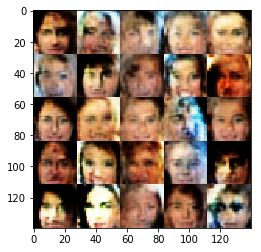

In [ ]:
batch_size = 24
z_dim = 100
learning_rate = 0.001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0004
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.